### installing libraries

In [1]:
!pip install geopy
!pip install folium
print('libraries installed')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 5.3 MB/s  eta 0:00:01
libraries installed


### Importing necessary libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

import folium # map rendering library

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Libraries imported.


In [3]:
# Credentials
CLIENT_ID = '0R15QYWA1PI5YH4LX1GHP2VZKLS4NZ3EWOACPOC1QOL3XEAH' # your Foursquare ID
CLIENT_SECRET = '0O5OOMWB4EZFEK0Y2GTBCH0S14CILZYOMZUXUTZJDROCXZP2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Scrap data from Wikipedia page into a DataFrame

In [4]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [5]:
# First rows of dataframe
data = get_new_york_data()
data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
# shape of dataframe
data.shape

(306, 4)

### Data analysis

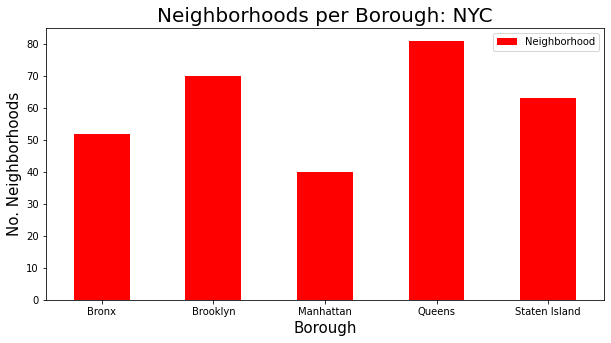

In [7]:
clr = "red"
data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

### Let's analyze further and see how many Indian restaurants there are in each neighborhood and borough. After it, we'll graph the results.

In [8]:
# defining get venues function
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [9]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    print(row)
    for resturant_detail in indian_restaurants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Indian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Indian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Indian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Indian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Indian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Indian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Indian Restaurants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Indian Restaurants in Norwood, Bronx:0
['Bronx', '

In [10]:
#indian_rest_ny.to_csv('indian_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
indian_rest_ny.to_csv('indian_rest_ny_tocsv1.csv')

In [11]:
indian_ny = pd.read_csv('indian_rest_ny_tocsv1.csv')
indian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
36,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant
37,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine
38,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux
39,Manhattan,Sutton Place,52645b7511d282d559770c2d,Adyar Anand Bhavans Pvt ltd
40,Manhattan,Flatiron,52a1fa08498ede15b1530912,Deep Indian Kitchen


In [12]:
indian_rest_ny.shape

(41, 4)

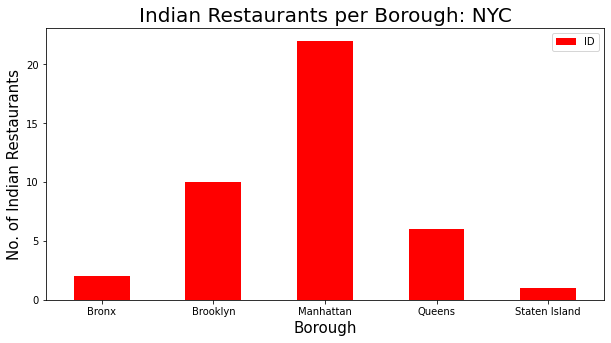

In [13]:
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()

plt.show()

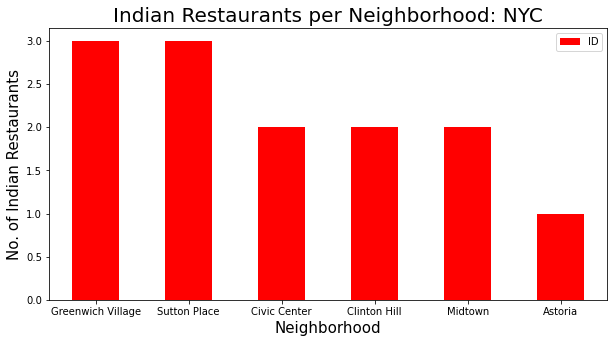

In [14]:
NOofNeigh = 6 # top number for graphing all the same past 6
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [15]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Sutton Place']

,Borough,Neighborhood,ID,Name
37,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine
38,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux
39,Manhattan,Sutton Place,52645b7511d282d559770c2d,Adyar Anand Bhavans Pvt ltd


In [16]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Greenwich Village']

,Borough,Neighborhood,ID,Name
19,Manhattan,Greenwich Village,4d992c1e942ba093ebb5968c,THELEwala
20,Manhattan,Greenwich Village,4593ed04f964a52050401fe3,The Kati Roll Company
21,Manhattan,Greenwich Village,56c931b2cd10407d3ecbefda,Ananda


We got 41 Indian Restaurants across the New York City.

As we continue our analysis, we see below that although Manhattan had the least number of neighborhoods, it does have the highest number of Indian restaurants. Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Greenwich village and Sutton Place has the highest number of Indian restaurants in all of NYC and is actually located in the boroughs of Manhattan.

So the Sutton Place & Greenwich Village in Manhattan has the highest number of Indian Restaurants with a total count of 3 each.

Now we will get the ranking of each restaurant for further analysis.

In [17]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [18]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
indian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '60e3c8a88492d94983da984c'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': 'entrance', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
36,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant,10,7.5,6
37,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine,155,8.0,58
38,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,77,8.1,82
39,Manhattan,Sutton Place,52645b7511d282d559770c2d,Adyar Anand Bhavans Pvt ltd,97,7.2,32
40,Manhattan,Flatiron,52a1fa08498ede15b1530912,Deep Indian Kitchen,680,7.4,132


In [19]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [20]:
indian_rest_stats_ny.shape

(41, 7)

We got statistics for all 41 Indian Restaurants in New York city.

Let's check what values we have in our DataFrame

In [21]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       41 non-null     object 
 1   Neighborhood  41 non-null     object 
 2   ID            41 non-null     object 
 3   Name          41 non-null     object 
 4   Likes         41 non-null     object 
 5   Rating        41 non-null     float64
 6   Tips          41 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.4+ KB


We see that the values like Likes, Tips are string values. We would need to convert them into float for further analysis

In [22]:
indian_rest_stats_ny['Likes'] = indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips'] = indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       41 non-null     object 
 1   Neighborhood  41 non-null     object 
 2   ID            41 non-null     object 
 3   Name          41 non-null     object 
 4   Likes         41 non-null     float64
 5   Rating        41 non-null     float64
 6   Tips          41 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.4+ KB


In [23]:
# descriptive stats of data
indian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,41.000000,41.000000,41.000000
mean,107.658537,7.278049,36.536585
std,190.768264,1.795343,52.643659
min,0.000000,0.000000,0.000000
25%,14.000000,7.200000,8.000000
50%,41.000000,7.600000,17.000000
75%,81.000000,8.100000,37.000000
max,835.000000,8.700000,257.000000


In [24]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                835
Rating                               8.2
Tips                                 257
Name: 16, dtype: object

In [25]:
# Resturant with maximum Ratings
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                607
Rating                               8.7
Tips                                 152
Name: 22, dtype: object

In [26]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                835
Rating                               8.2
Tips                                 257
Name: 16, dtype: object

### Now identify and visualize neighborhood with the maximum average rating of restaurants

In [37]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
28,Tribeca,8.700000
0,Astoria,8.600000
7,Chelsea,8.600000
25,Prospect Lefferts Gardens,8.500000
24,Noho,8.400000
23,New Dorp,8.400000
15,Greenwich Village,8.233333
32,Woodlawn,8.100000
31,West Village,8.100000
22,Midtown,8.100000


Above are the top neighborhoods with the highest average ratings of Indian restaurants.

In [28]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
4,Staten Island,8.40
2,Manhattan,7.80
1,Brooklyn,7.16
3,Queens,6.45
0,Bronx,4.05



Similarly these are the average ratings of Japanese Restaurants for each Borough

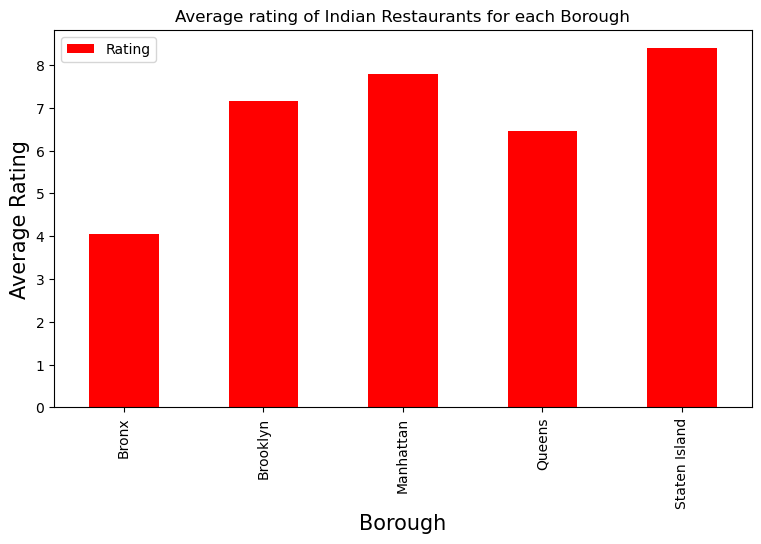

In [29]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Indian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

We will consider all the neighborhoods with average rating greater or equal 7.5 to visualize on a map

In [30]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.5]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,8.600000
2,Bayside,7.900000
6,Carnegie Hill,7.800000
7,Chelsea,8.600000
10,Financial District,7.700000
12,Fort Greene,7.800000
15,Greenwich Village,8.233333
17,Jamaica Hills,7.500000
18,Kew Gardens,7.600000
22,Midtown,8.100000


In [36]:
#  join this Dataset to original New York data to get longitude and latitude
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.600000
1,Queens,Bayside,40.766041,-73.774274,7.900000
2,Manhattan,Carnegie Hill,40.782683,-73.953256,7.800000
3,Manhattan,Chelsea,40.744035,-74.003116,8.600000
4,Staten Island,Chelsea,40.594726,-74.189560,8.600000
5,Manhattan,Chelsea,40.744035,-74.003116,8.600000
6,Staten Island,Chelsea,40.594726,-74.189560,8.600000
7,Manhattan,Chelsea,40.744035,-74.003116,8.600000
8,Staten Island,Chelsea,40.594726,-74.189560,8.600000
9,Manhattan,Chelsea,40.744035,-74.003116,8.600000


In [32]:
# creating a map
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [33]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [34]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

## Results 
Manhattan and Staten Island have the best rated Indian restaurants on average. Queens and The Bronx have the least amount of Indian restaurants per borough. However, of note, Greenvich Village & Sutton Palace in Manhattan has the highest number of Indian Restaurants in all of NY. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most number of Indian restaurants. Based on the above information, I would state that Manhattan and Staten Island are the best locations for Japanese cuisine in NYC. To have the best shot of success, I would open a Indian restaurant in Brooklyn. Brooklyn has multiple neighborhoods with average ratings exceeding 8.0 on a scale of 1.0 to 10.0 and has less amount of Indian restaurants than Manhattan and Staten island, making competition easier. Also we should keep in mind, that real estate prices in Brooklyn are much cheaper than in Manhattan. Finally, I would go to The Kati Roll Company in Manhattan for the best Indian food based on 835 likes. As a final note, all of the above analysis is depended on the accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.